Performing optimizations with SciPy...
  NIT    FC           OBJFUN            GNORM
    1     4    -1.000006E+00     2.119267E-03
    2     7    -1.000033E+00     2.109752E-03
    3    10    -1.000165E+00     2.059517E-03
    4    13    -1.000461E+00     1.729652E-03
    5    16    -1.000347E+00     3.433245E-03
    6    22    -1.000431E+00     2.958143E-03
    7    35    -1.000429E+00     2.954903E-03
    8    48    -1.000430E+00     2.951276E-03
    9    57    -1.000431E+00     2.910705E-03
   10    66    -1.000432E+00     2.870864E-03
   11    76    -1.000432E+00     2.849084E-03
   12    85    -1.000433E+00     2.809207E-03
   13    94    -1.000433E+00     2.770116E-03
   14   104    -1.000434E+00     2.748816E-03
   15   113    -1.000434E+00     2.709871E-03
   16   123    -1.000435E+00     2.688699E-03
   17   132    -1.000436E+00     2.650088E-03
   18   142    -1.000436E+00     2.629132E-03
   19   151    -1.000437E+00     2.590987E-03
   20   161    -1.000437E+00     2.570323

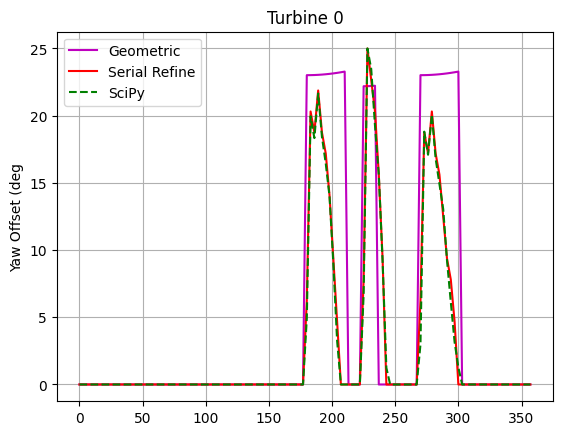

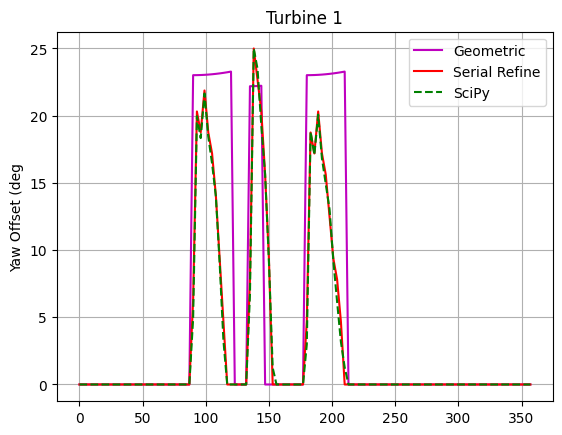

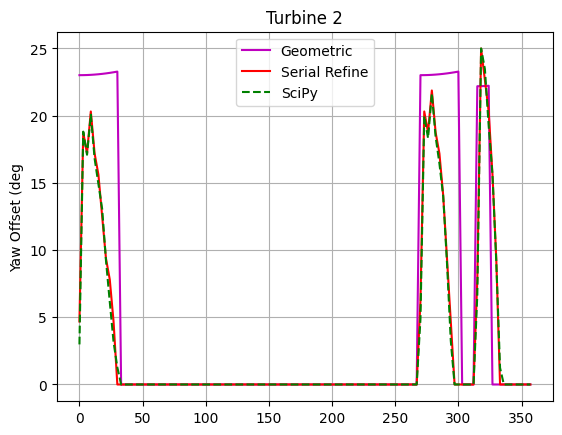

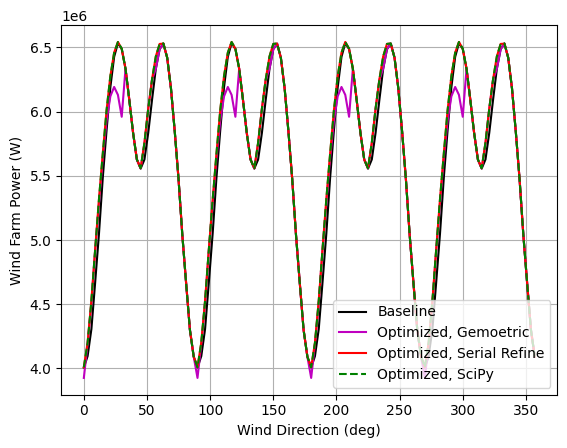

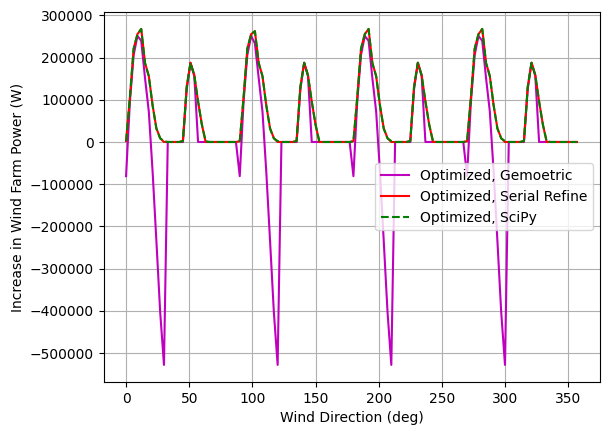

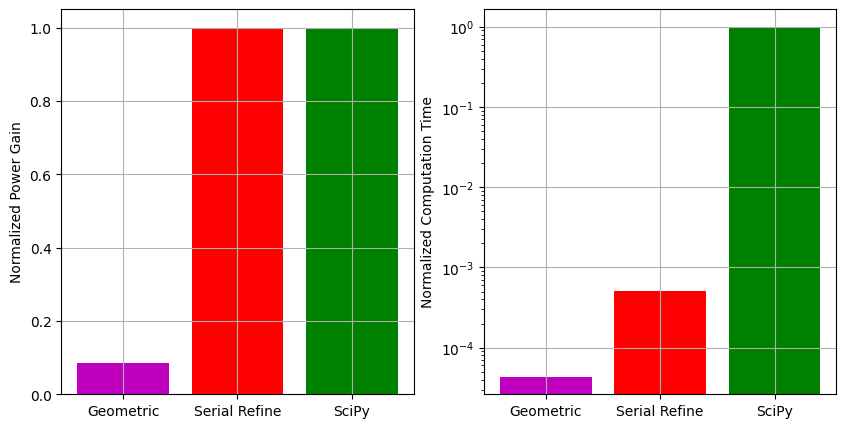

In [1]:
from time import perf_counter as timerpc

import matplotlib.pyplot as plt
import numpy as np

from floris import FlorisModel
from floris.optimization.yaw_optimization.yaw_optimizer_geometric import (
    YawOptimizationGeometric,
)
from floris.optimization.yaw_optimization.yaw_optimizer_scipy import YawOptimizationScipy
from floris.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR


# Load the default example floris object
fmodel = FlorisModel("data/gch.yaml")

# Reinitialize as a 3-turbine farm with range of WDs and 1 WS
diam = 126.0 # Rotor diameter for the NREL 5 MW
wd_array = np.arange(0.0, 360.0, 3.0)
ws_array = 8.0 * np.ones_like(wd_array)
turbulence_intensities = 0.06 * np.ones_like(wd_array)
fmodel.set(
    layout_x=[0.0, 250.0, 0.0, 250.0],#[0.0, 5 * D, 10 * D],
    layout_y=[0.0, 0.0, 250.0, 250.0],#[0.0, 0.0, 0.0],
    wind_directions=wd_array,
    wind_speeds=ws_array,
    turbulence_intensities=turbulence_intensities,
)

print("Performing optimizations with SciPy...")
start_time = timerpc()
yaw_opt_scipy = YawOptimizationScipy(fmodel)
df_opt_scipy = yaw_opt_scipy.optimize()
time_scipy = timerpc() - start_time

print("Performing optimizations with Serial Refine...")
start_time = timerpc()
yaw_opt_sr = YawOptimizationSR(fmodel)
df_opt_sr = yaw_opt_sr.optimize()
time_sr = timerpc() - start_time

print("Performing optimizations with Geometric Yaw...")
start_time = timerpc()
yaw_opt_geo = YawOptimizationGeometric(fmodel)
df_opt_geo = yaw_opt_geo.optimize()
time_geo = timerpc() - start_time



# Print time spent
print("\n Time spent, Geometric Yaw: {:.2f} s.".format(time_geo))
print(" Time spent, Serial Refine: {:.2f} s.".format(time_sr))
print(" Time spent, SciPy (SLSQP): {:.2f} s.\n".format(time_scipy))

# Split out the turbine results
yaw_angles_opt_geo = np.vstack(df_opt_geo.yaw_angles_opt)
yaw_angles_opt_sr = np.vstack(df_opt_sr.yaw_angles_opt)
yaw_angles_opt_scipy = np.vstack(df_opt_scipy.yaw_angles_opt)


# Yaw results
for t in range(3):
    fig, ax = plt.subplots()
    ax.plot(df_opt_geo.wind_direction, yaw_angles_opt_geo[:, t],color='m',label='Geometric')
    ax.plot(df_opt_sr.wind_direction, yaw_angles_opt_sr[:, t],color='r',label='Serial Refine')
    ax.plot(df_opt_scipy.wind_direction, yaw_angles_opt_scipy[:, t],'--', color='g', label='SciPy')
    ax.grid(True)
    ax.set_ylabel('Yaw Offset (deg')
    ax.legend()
    ax.grid(True)
    ax.set_title("Turbine {:d}".format(t))

# Power results ==============

# Before plotting results, need to compute values for GEOOPT since it doesn't compute
# power within the optimization
fmodel.set(yaw_angles=yaw_angles_opt_geo)
fmodel.run()
geo_farm_power = fmodel.get_farm_power().squeeze()


fig, ax = plt.subplots()
ax.plot(
    df_opt_sr.wind_direction,
    df_opt_sr.farm_power_baseline,
    color='k',
    label='Baseline'
)
ax.plot(
    df_opt_geo.wind_direction,
    geo_farm_power,
    color='m',
    label='Optimized, Gemoetric'
)
ax.plot(
    df_opt_sr.wind_direction,
    df_opt_sr.farm_power_opt,
    color='r',
    label='Optimized, Serial Refine'
)
ax.plot(
    df_opt_scipy.wind_direction,
    df_opt_scipy.farm_power_opt,
    '--',
    color='g',
    label='Optimized, SciPy'
)
ax.set_ylabel('Wind Farm Power (W)')
ax.set_xlabel('Wind Direction (deg)')
ax.legend()
ax.grid(True)

# Finally, compare the overall the power gains

fig, ax = plt.subplots()

ax.plot(
    df_opt_geo.wind_direction,
    geo_farm_power - df_opt_sr.farm_power_baseline,
    color='m',
    label='Optimized, Gemoetric'
)
ax.plot(
    df_opt_sr.wind_direction,
    df_opt_sr.farm_power_opt - df_opt_sr.farm_power_baseline,
    color='r',
    label='Optimized, Serial Refine'
)
ax.plot(
    df_opt_scipy.wind_direction,
    df_opt_scipy.farm_power_opt - df_opt_scipy.farm_power_baseline,
    '--',
    color='g',
    label='Optimized, SciPy'
)
ax.set_ylabel('Increase in Wind Farm Power (W)')
ax.set_xlabel('Wind Direction (deg)')
ax.legend()
ax.grid(True)


# Finally, make a quick bar plot comparing nomimal power and nomimal uplift
total_power_uplift_geo = np.sum(geo_farm_power - df_opt_sr.farm_power_baseline)
total_power_uplift_sr = np.sum(df_opt_sr.farm_power_opt - df_opt_sr.farm_power_baseline)
total_power_uplift_scipy = np.sum(df_opt_scipy.farm_power_opt - df_opt_scipy.farm_power_baseline)

# Plot on the left subplot a barplot comparing the uplift normalized to scipy and on the right
# subplot a barplot of total time normalzed to scipy
fig, axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]
ax.bar(
    [0, 1, 2],
    [
        total_power_uplift_geo / total_power_uplift_scipy,
        total_power_uplift_sr / total_power_uplift_scipy,
        1.0,
    ],
    color=['m', 'r', 'g'],
)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Geometric', 'Serial Refine', 'SciPy'])
ax.set_ylabel('Normalized Power Gain')
ax.grid(True)

ax = axarr[1]
ax.bar(
    [0, 1, 2],
    [
        time_geo / time_scipy,
        time_sr / time_scipy,
        1.0,
    ],
    color=['m', 'r', 'g'],
)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Geometric', 'Serial Refine', 'SciPy'])
ax.set_ylabel('Normalized Computation Time')
ax.grid(True)

# Change to semi-logy
axarr[1].set_yscale('log')

plt.show()
import warnings
warnings.filterwarnings('ignore')

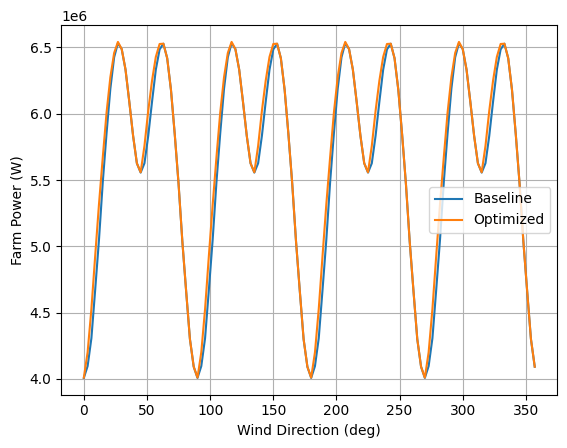

In [2]:
from pathlib import Path
Path("data/serial_refine").mkdir(parents=True, exist_ok=True)

np.save("data/serial_refine/wind_direction", df_opt_sr.wind_direction)
np.save("data/serial_refine/farm_power_opt", df_opt_sr.farm_power_opt)

# Plot them
fig, ax = plt.subplots()
ax.plot(df_opt_sr.wind_direction, df_opt_sr.farm_power_baseline, label="Baseline")
ax.plot(df_opt_sr.wind_direction, df_opt_sr.farm_power_opt, label="Optimized")
ax.set_xlabel("Wind Direction (deg)")
ax.set_ylabel("Farm Power (W)")
ax.legend()
ax.grid(True)
plt.show()


# Rendering in the environment

In [2]:
# Wind process that implements a sequence of wind speeds and directions
from wind_processes import SetSequenceWindProcess

[221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]


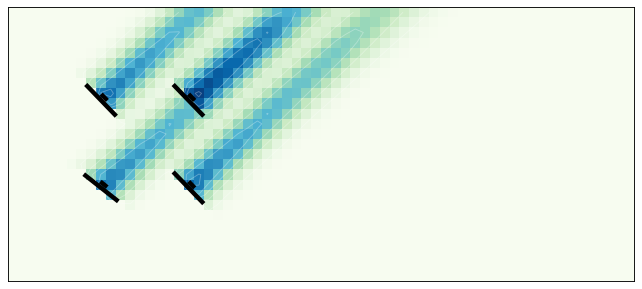

In [9]:
from env_utils import get_4wt_symmetric_env

env = get_4wt_symmetric_env(episode_length=100, privileged=False, action_representation="yaw", load_pyglet_visualization=True)
repeat = 10
middle_angle = 226
offset = 5
starting_time_offset = 40
wind_directions = [middle_angle-offset]*starting_time_offset
for i in range(offset*2):
    wind_directions.extend([middle_angle + (i - offset)]*repeat)
env.wind_process = SetSequenceWindProcess(wind_directions=wind_directions, wind_speeds=[8.]*len(wind_directions))
print(wind_directions)
# Get proportional controller
from serial_refine_agent import SR_ProportionalController

agent = SR_ProportionalController()

# Run the environment
done = False
imgs = []
obs = env.reset()
for i in range(100):
    wind_direction = env.wind_process.wind_direction
    current_yaws = env.yaws_from_wind

    action = agent.predict(wind_direction, current_yaws)
    obs, reward, terminated, truncated, info = env.step(action)

    env.render()
    imgs.append(env.render(mode='rgb_array'))
    if terminated or truncated:
        break

In [17]:
from PIL import Image

ofs_top = 0
l = 300
imgs_pil = [Image.fromarray(img[ofs_top:ofs_top+l, ofs_top+7:ofs_top+l]) for img in imgs]

# Save gif
imgs_pil[starting_time_offset].save("data/serial_refine/critical_angle.gif", save_all=True, append_images=imgs_pil[starting_time_offset+1:], loop=0, duration=100)

# Run FlorisSR on bigger envs

In [8]:
from time import perf_counter as timerpc

import matplotlib.pyplot as plt
import numpy as np

from floris import FlorisModel
from floris.optimization.yaw_optimization.yaw_optimizer_geometric import (
    YawOptimizationGeometric,
)
from floris.optimization.yaw_optimization.yaw_optimizer_scipy import YawOptimizationScipy
from floris.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

def run_floris_sr(turbine_layout):
    # Load the default example floris object
    fmodel = FlorisModel("data/gch.yaml")

    # Reinitialize as a 3-turbine farm with range of WDs and 1 WS
    D = 126.0 # Rotor diameter for the NREL 5 MW
    wd_array = np.arange(0.0, 360.0, 3.0)
    ws_array = 8.0 * np.ones_like(wd_array)
    turbulence_intensities = 0.06 * np.ones_like(wd_array)
    x, y = turbine_layout
    fmodel.set(
        layout_x=x,
        layout_y=y,
        wind_directions=wd_array,
        wind_speeds=ws_array,
        turbulence_intensities=turbulence_intensities,
    )

    print("Performing optimizations with Serial Refine...")
    start_time = timerpc()
    yaw_opt_sr = YawOptimizationSR(fmodel)
    df_opt_sr = yaw_opt_sr.optimize()
    time_sr = timerpc() - start_time


    # Print time spent
    print(" Time spent, Serial Refine: {:.2f} s.".format(time_sr))

    # Split out the turbine results
    yaw_angles_opt_sr = np.vstack(df_opt_sr.yaw_angles_opt)


    # Yaw results
    for t in range(4):
        fig, ax = plt.subplots()
        ax.plot(df_opt_sr.wind_direction, yaw_angles_opt_sr[:, t],color='r',label='Serial Refine')
        ax.grid(True)
        ax.set_ylabel('Yaw Offset (deg')
        ax.legend()
        ax.grid(True)
        ax.set_title("Turbine {:d}".format(t))

    # Power results ==============

    fig, ax = plt.subplots()
    ax.plot(
        df_opt_sr.wind_direction,
        df_opt_sr.farm_power_baseline,
        color='k',
        label='Baseline'
    )
    ax.plot(
        df_opt_sr.wind_direction,
        df_opt_sr.farm_power_opt,
        color='r',
        label='Optimized, Serial Refine'
    )
    ax.set_ylabel('Wind Farm Power (W)')
    ax.set_xlabel('Wind Direction (deg)')
    ax.legend()
    ax.grid(True)

    # Finally, compare the overall the power gains

    fig, ax = plt.subplots()

    ax.plot(
        df_opt_sr.wind_direction,
        df_opt_sr.farm_power_opt - df_opt_sr.farm_power_baseline,
        color='r',
        label='Optimized, Serial Refine'
    )
    ax.set_ylabel('Increase in Wind Farm Power (W)')
    ax.set_xlabel('Wind Direction (deg)')
    ax.legend()
    ax.grid(True)

    return yaw_angles_opt_sr, df_opt_sr

# Run floris SR on 16 lhs env

Performing optimizations with Serial Refine...
[Serial Refine] Processing pass=0, turbine_depth=0 (0.0%)
[Serial Refine] Processing pass=0, turbine_depth=1 (3.1%)
[Serial Refine] Processing pass=0, turbine_depth=2 (6.2%)
[Serial Refine] Processing pass=0, turbine_depth=3 (9.4%)
[Serial Refine] Processing pass=0, turbine_depth=4 (12.5%)
[Serial Refine] Processing pass=0, turbine_depth=5 (15.6%)
[Serial Refine] Processing pass=0, turbine_depth=6 (18.8%)
[Serial Refine] Processing pass=0, turbine_depth=7 (21.9%)
[Serial Refine] Processing pass=0, turbine_depth=8 (25.0%)
[Serial Refine] Processing pass=0, turbine_depth=9 (28.1%)
[Serial Refine] Processing pass=0, turbine_depth=10 (31.2%)
[Serial Refine] Processing pass=0, turbine_depth=11 (34.4%)
[Serial Refine] Processing pass=0, turbine_depth=12 (37.5%)
[Serial Refine] Processing pass=0, turbine_depth=13 (40.6%)
[Serial Refine] Processing pass=0, turbine_depth=14 (43.8%)
[Serial Refine] Processing pass=0, turbine_depth=15 (46.9%)
[Serial

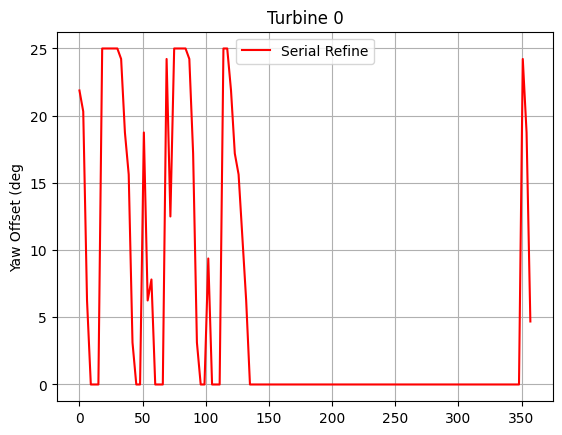

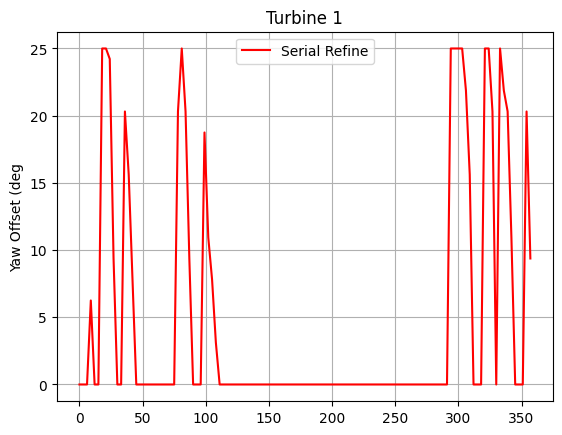

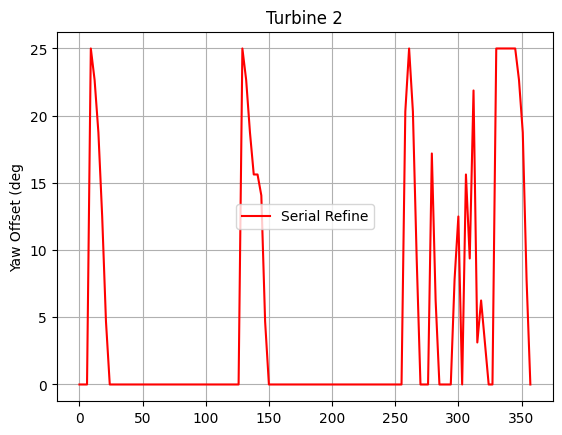

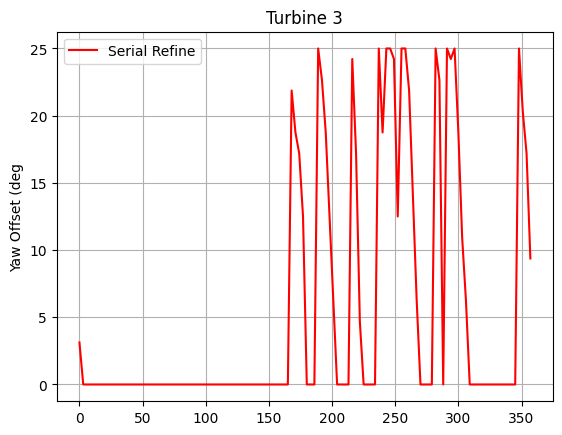

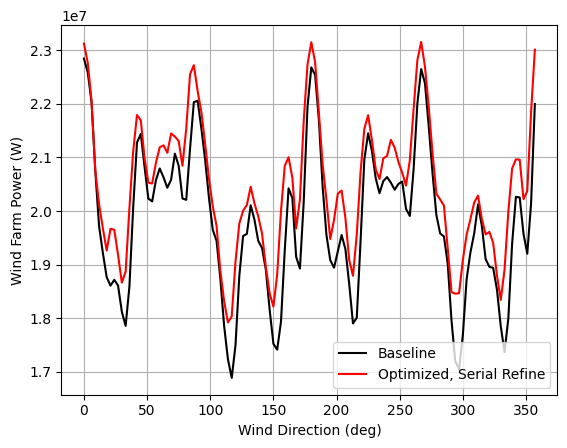

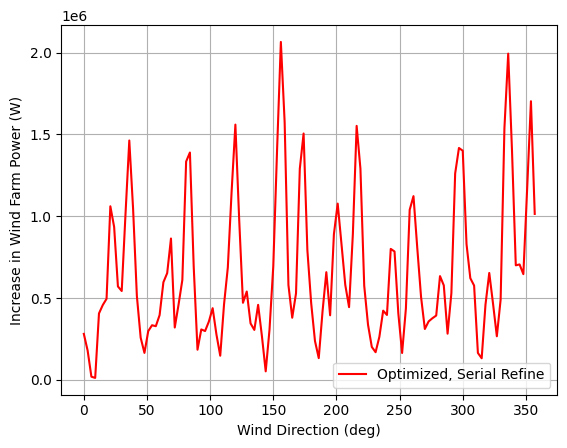

In [9]:

yaw_angles_opt_sr, df_opt_sr = run_floris_sr(np.load("data/layouts/lhs_env_nt16_md75_wb1500x1500_turbine_layout.npy"))
# Save optimal yaws
np.save("data/serial_refine/lhs16_yaw_angles_opt", yaw_angles_opt_sr)
np.save("data/serial_refine/lhs16_wind_direction", df_opt_sr.wind_direction)

# Run floris SR on 8 wt env

Performing optimizations with Serial Refine...


floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.


[Serial Refine] Processing pass=0, turbine_depth=0 (0.0%)


floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.


[Serial Refine] Processing pass=0, turbine_depth=1 (6.2%)
[Serial Refine] Processing pass=0, turbine_depth=2 (12.5%)
[Serial Refine] Processing pass=0, turbine_depth=3 (18.8%)
[Serial Refine] Processing pass=0, turbine_depth=4 (25.0%)
[Serial Refine] Processing pass=0, turbine_depth=5 (31.2%)
[Serial Refine] Processing pass=0, turbine_depth=6 (37.5%)
[Serial Refine] Processing pass=0, turbine_depth=7 (43.8%)
[Serial Refine] Processing pass=1, turbine_depth=0 (50.0%)
[Serial Refine] Processing pass=1, turbine_depth=1 (56.2%)
[Serial Refine] Processing pass=1, turbine_depth=2 (62.5%)
[Serial Refine] Processing pass=1, turbine_depth=3 (68.8%)
[Serial Refine] Processing pass=1, turbine_depth=4 (75.0%)
[Serial Refine] Processing pass=1, turbine_depth=5 (81.2%)
[Serial Refine] Processing pass=1, turbine_depth=6 (87.5%)
[Serial Refine] Processing pass=1, turbine_depth=7 (93.8%)
 Time spent, Serial Refine: 23.00 s.


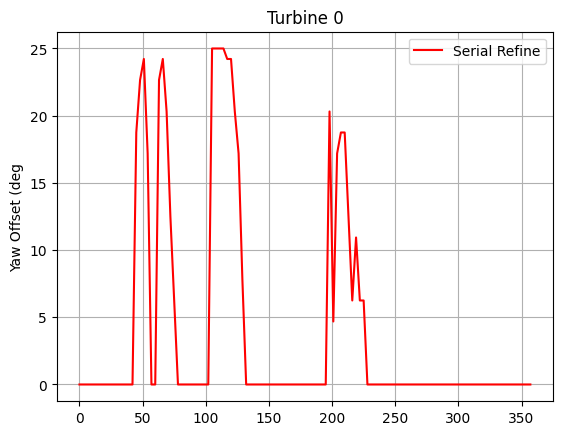

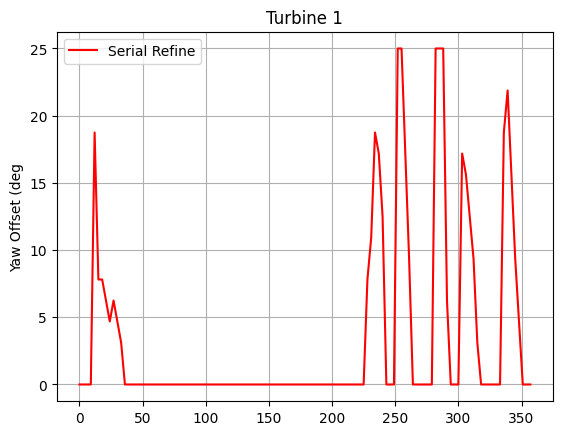

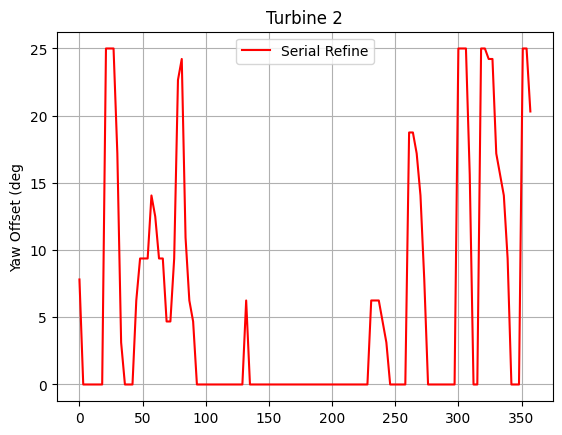

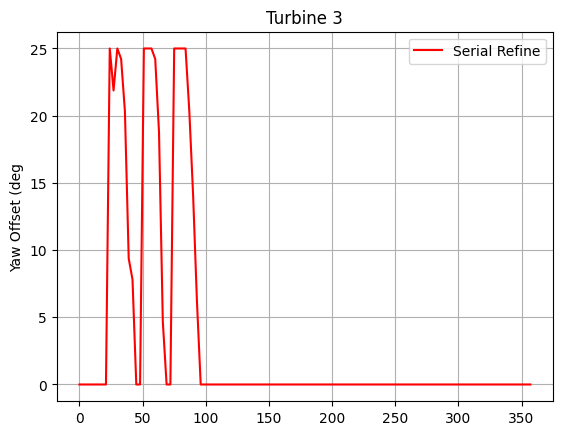

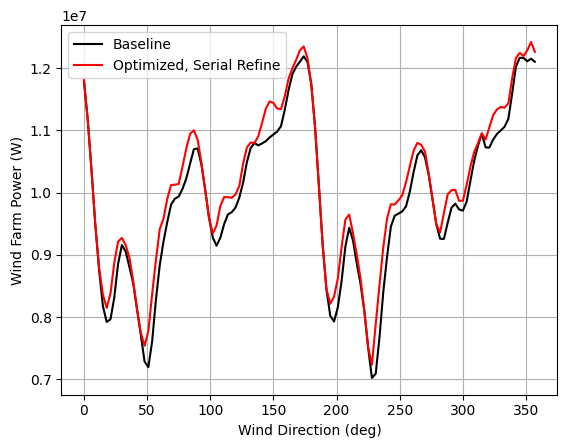

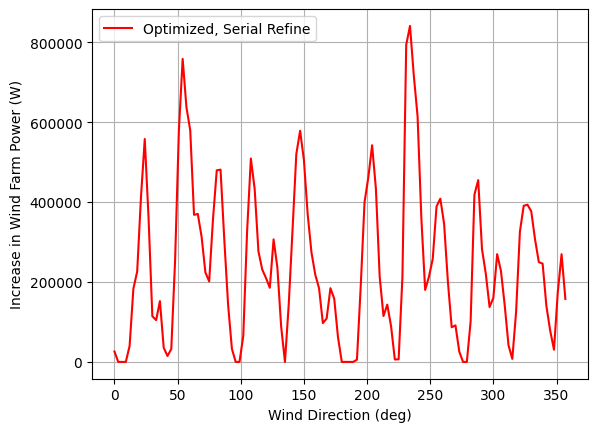

In [10]:
yaw_angles_opt_sr, df_opt_sr = run_floris_sr(np.load("data/layouts/lhs_env_nt8_md150_wb750x750_turbine_layout.npy"))
# Save optimal yaws
np.save("data/serial_refine/lhs8_yaw_angles_opt", yaw_angles_opt_sr)
np.save("data/serial_refine/lhs8_wind_direction", df_opt_sr.wind_direction)